In [3]:
# ================================
# GENN-Q: Genetic Expression Neural Network with Quantum-Inspired Activation
# Prototipo Colab — 3 Benchmarks (Iris, Mackey-Glass, CartPole Imitation)
# ================================

# ==== Instalación de dependencias (Colab) ====
!pip -q install deap gymnasium[classic-control] --upgrade

import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from deap import base, creator, tools, algorithms
import gymnasium as gym
from typing import Tuple, List

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# 1) Núcleo GENN-Q
# ================================

class QuantumActivation(nn.Module):
    """
    Activación cuántico-inspirada:
    y = cos^2(phi) * tanh(x) + sin^2(phi) * sin(beta * x)
    donde phi, beta son parámetros (aquí optimizados por la evolución).
    """
    def __init__(self, phi: float = 0.7, beta: float = 1.0):
        super().__init__()
        # Usamos parámetros "buffer" para que puedan setearse desde el exterior (no se entrenan por gradiente aquí)
        self.register_buffer('phi', torch.tensor([phi], dtype=torch.float32))
        self.register_buffer('beta', torch.tensor([beta], dtype=torch.float32))

    def forward(self, x):
        c2 = torch.cos(self.phi)**2
        s2 = torch.sin(self.phi)**2
        return c2 * torch.tanh(x) + s2 * torch.sin(self.beta * x)

    def set_params(self, phi: float, beta: float):
        self.phi = torch.tensor([phi], dtype=torch.float32, device=self.phi.device)
        self.beta = torch.tensor([beta], dtype=torch.float32, device=self.beta.device)


class GeneMask(nn.Module):
    """
    Máscara de expresión génica por-neurona (binaria) aplicada a la salida de una capa.
    """
    def __init__(self, size: int, mask: np.ndarray = None):
        super().__init__()
        if mask is None:
            mask = (np.random.rand(size) > 0.3).astype(np.float32)  # ~70% activas iniciales
        self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32))

    def forward(self, x):
        # x: (batch, size)
        return x * self.mask

    def set_mask(self, mask: np.ndarray):
        self.mask = torch.tensor(mask.astype(np.float32), dtype=torch.float32, device=self.mask.device)

    def sparsity(self) -> float:
        # proporción de neuronas apagadas (1 - activas/total)
        return 1.0 - float(self.mask.sum().item()) / float(self.mask.numel())


class GENNQNet(nn.Module):
    """
    MLP 2 capas con:
    - activación cuántico-inspirada entre capas
    - máscaras génicas en capa oculta y salida (opcional)
    """
    def __init__(self, in_dim: int, hidden: int, out_dim: int, task: str = "classification"):
        super().__init__()
        self.task = task
        self.fc1 = nn.Linear(in_dim, hidden)
        self.act_q = QuantumActivation()
        self.mask1 = GeneMask(hidden)
        self.fc2 = nn.Linear(hidden, out_dim)
        # Para series regresión: salida lineal; para clasificación: logits
        # (Opcional) máscara a la salida si se desea (normalmente no):
        self.use_out_mask = False
        if self.use_out_mask:
            self.mask2 = GeneMask(out_dim)

    def forward(self, x):
        z = self.fc1(x)
        z = self.act_q(z)
        z = self.mask1(z)
        z = self.fc2(z)
        if self.use_out_mask:
            z = self.mask2(z)
        return z

    # --- Helpers de seteo por evolución ---
    def set_gene_mask_hidden(self, mask: np.ndarray):
        self.mask1.set_mask(mask)

    def set_quantum_params(self, phi: float, beta: float):
        self.act_q.set_params(phi, beta)

    def total_sparsity(self) -> float:
        return self.mask1.sparsity()


# ================================
# 2) Entrenamiento/validación estándar
# ================================

def train_model(model, train_loader, val_loader, task="classification",
                epochs=20, lr=1e-3, weight_decay=0.0, verbose=False):
    model = model.to(device)
    if task == "classification":
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = None
    best_state = None

    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

        # Validación
        model.eval()
        with torch.no_grad():
            val_losses = []
            y_true, y_pred = [], []
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                if task == "classification":
                    loss = criterion(pred, yb)
                    y_true.extend(yb.cpu().numpy())
                    y_pred.extend(torch.argmax(pred, dim=1).cpu().numpy())
                else:
                    loss = criterion(pred, yb)
                    y_true.extend(yb.cpu().numpy().reshape(-1))
                    y_pred.extend(pred.cpu().numpy().reshape(-1))
                val_losses.append(loss.item())

            if task == "classification":
                metric = accuracy_score(y_true, y_pred)
                score = metric  # mayor es mejor
            else:
                metric = mean_squared_error(y_true, y_pred)
                score = -metric  # menor MSE = mejor score

            if (best_val is None) or (score > best_val):
                best_val = score
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if verbose and ep % 5 == 0:
            if task == "classification":
                print(f"[{task}] Epoch {ep:03d} | Val Acc = {metric:.4f}")
            else:
                print(f"[{task}] Epoch {ep:03d} | Val MSE = {metric:.6f}")

    # Restaurar mejor estado
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    return model, best_val


# ================================
# 3) Evolución (NSGA-II con DEAP)
#    Genotipo: [phi, beta, mask_hidden_bits...]
#    Objetivos: (-performance) y (sparsidad) -> minimización en ambos
# ================================

def make_toolbox(model_fn, data_fn, task: str, in_dim: int, hidden: int, out_dim: int,
                 train_epochs=15, pop_size=12, cxpb=0.8, mutpb=0.2, ngen=6, batch=64):

    # Ensure pop_size is a multiple of 4 for selTournamentDCD
    if pop_size % 4 != 0:
        pop_size = (pop_size // 4 + 1) * 4
        print(f"Adjusted pop_size to {pop_size} to be a multiple of 4 for NSGA-II.")


    # Data
    Xtr, ytr, Xval, yval = data_fn()
    if task == "classification":
        ytr_t = torch.tensor(ytr, dtype=torch.long)
        yval_t = torch.tensor(yval, dtype=torch.long)
    else:
        ytr_t = torch.tensor(ytr, dtype=torch.float32).view(-1, 1 if out_dim==1 else out_dim)
        yval_t = torch.tensor(yval, dtype=torch.float32).view(-1, 1 if out_dim==1 else out_dim)

    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    Xval_t = torch.tensor(Xval, dtype=torch.float32)

    tr_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch, shuffle=True)
    val_loader = DataLoader(TensorDataset(Xval_t, yval_t), batch_size=batch, shuffle=False)

    # DEAP setup
    creator.create("FitnessMin", base.Fitness, weights=(-1.0, +1.0))  # min perf (negado) y MAX sparsidad? -> mejor: ( -perf , +sparsity )
    # Nota: Usamos (+1.0) en sparsidad para "maximizar" la sparsidad; equivaldría a minimizar neuronas activas.
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    # Rango de parámetros cuánticos
    PHI_MIN, PHI_MAX = 0.0, math.pi/2
    BETA_MIN, BETA_MAX = 0.2, 3.0

    # Inicialización
    def init_individual():
        phi = random.uniform(PHI_MIN, PHI_MAX)
        beta = random.uniform(BETA_MIN, BETA_MAX)
        mask = (np.random.rand(hidden) > 0.2).astype(np.int8)  # 80% activas al inicio
        return creator.Individual([phi, beta] + mask.tolist())

    toolbox.register("individual", init_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Evaluación
    def eval_ind(individual):
        phi = float(individual[0]); beta = float(individual[1])
        mask_bits = np.array(individual[2:], dtype=np.float32)

        model = model_fn(in_dim, hidden, out_dim, task).to(device)
        model.set_quantum_params(phi, beta)
        model.set_gene_mask_hidden(mask_bits)

        model, best_val = train_model(model, tr_loader, val_loader, task=task, epochs=train_epochs, lr=1e-3, weight_decay=0.0, verbose=False)

        # Performance para minimizar (negamos score según tarea)
        if task == "classification":
            perf = -float(best_val)  # accuracy negada
        else:
            perf = -float(best_val)  # usamos score=-MSE, negarlo invierte; aquí queda minimizable

        sparsity = model.total_sparsity()  # 0..1 (mayor = más sparse)

        return perf, sparsity

    toolbox.register("evaluate", eval_ind)

    # Cruce: mezcla de (phi,beta) y máscara 1p
    def mate(ind1, ind2):
        # mezclar phi/beta (promedios + ligera perturbación)
        for i in [0,1]:
            if random.random() < 0.5:
                a = (ind1[i] + ind2[i]) / 2.0
            else:
                a = 0.5*ind1[i] + 0.5*ind2[i] + random.uniform(-0.05, 0.05)
            ind1[i] = max(PHI_MIN if i==0 else BETA_MIN, min(PHI_MAX if i==0 else BETA_MAX, a))
        # máscara: 1-point crossover
        point = random.randint(2, len(ind1)-1)
        tail1 = ind1[point:]; tail2 = ind2[point:]
        ind1[point:], ind2[point:] = tail2, tail1
        return ind1, ind2

    # Mutación: ruido en phi/beta y flips en máscara
    def mutate(ind):
        if random.random() < 0.7:
            ind[0] = max(PHI_MIN, min(PHI_MAX, ind[0] + random.uniform(-0.1, 0.1)))
        if random.random() < 0.7:
            ind[1] = max(BETA_MIN, min(BETA_MAX, ind[1] + random.uniform(-0.2, 0.2)))
        for i in range(2, len(ind)):
            if random.random() < 0.05:
                ind[i] = 1 - ind[i]
        return (ind,)

    toolbox.register("mate", mate)
    toolbox.register("mutate", mutate)
    toolbox.register("select", tools.selNSGA2)

    # Empaquetamos también datos para uso externo
    toolbox.data = (tr_loader, val_loader)
    toolbox.config = dict(pop_size=pop_size, cxpb=cxpb, mutpb=mutpb, ngen=ngen)
    return toolbox


def run_evolution(toolbox):
    pop = toolbox.population(n=toolbox.config["pop_size"])
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # NSGA-II estándar
    pop = tools.selNSGA2(pop, len(pop))
    print("Initial population evaluation...")
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)
        print(f"Individual fitness: {ind.fitness.values}")

    print("\nStarting evolution...")
    for gen in range(1, toolbox.config["ngen"]+1):
        print(f"-- Generation {gen} --")
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= toolbox.config["cxpb"]:
                toolbox.mate(ind1, ind2)
            toolbox.mutate(ind1)
            del ind1.fitness.values, ind2.fitness.values
        invalid = [ind for ind in offspring if not ind.fitness.valid]
        print(f"Evaluating {len(invalid)} invalid individuals...")
        for ind in invalid:
            ind.fitness.values = toolbox.evaluate(ind)
            print(f"Individual fitness: {ind.fitness.values}")

        pop = tools.selNSGA2(pop + offspring, len(pop))
        hof.update(pop)

        # Log statistics
        record = stats.compile(pop)
        print(f"Gen {gen:02d} | Avg Fit: {record['avg']} | Std Dev Fit: {record['std']} | Min Fit: {record['min']} | Max Fit: {record['max']}")

    print("\nEvolution finished.")
    return pop, hof


# ================================
# 4) Datasets
# ================================

# ---- 4.1 IRIS (Clasificación) ----
def load_iris():
    iris = datasets.load_iris()
    X = iris.data.astype(np.float32)
    y = iris.target.astype(np.int64)
    X = StandardScaler().fit_transform(X)
    # split 80/20
    n = len(X); ntr = int(0.8*n)
    idx = np.random.permutation(n)
    tr, val = idx[:ntr], idx[ntr:]
    return X[tr], y[tr], X[val], y[val]

# ---- 4.2 Mackey-Glass (Series temporales) ----
def mackey_glass(T=1200, tau=17, delta_t=1, beta=0.2, gamma=0.1, n=10, x0=1.2):
    # generamos serie
    T = int(T)
    x = np.zeros(T + tau + 1, dtype=np.float64)
    x[:tau+1] = x0
    for t in range(tau, T+tau):
        x[t+1] = x[t] + delta_t*(beta * x[t - tau] / (1 + x[t - tau]**n) - gamma * x[t])
    return x[tau+1:]  # largo T

def make_mg_supervised(series, lag=10, horizon=1):
    X, y = [], []
    for i in range(len(series) - lag - horizon + 1):
        X.append(series[i:i+lag])
        y.append(series[i+lag+horizon-1])
    X = np.array(X, dtype=np.float32); y = np.array(y, dtype=np.float32)
    return X, y

def load_mg():
    s = mackey_glass(T=1500)
    # Normalizamos
    scaler = MinMaxScaler()
    s = scaler.fit_transform(s.reshape(-1,1)).reshape(-1)
    X, y = make_mg_supervised(s, lag=12, horizon=1)
    n = len(X); ntr = int(0.8*n)
    return X[:ntr], y[:ntr], X[ntr:], y[ntr:]

# ---- 4.3 CartPole Imitation (Control) ----
def collect_cartpole_dataset(n_episodes=60, max_steps=200):
    """
    Política heurística simple: acción = 1 si angle + 0.5*angle_dot > 0 else 0
    Entrenaremos un clasificador (BC) estado->acción.
    """
    env = gym.make("CartPole-v1")
    X, y = [], []
    for _ in range(n_episodes):
        s, _ = env.reset(seed=random.randint(0,10000))
        for _ in range(max_steps):
            x, x_dot, theta, theta_dot = s
            a = 1 if (theta + 0.5*theta_dot) > 0 else 0
            X.append(np.array([x, x_dot, theta, theta_dot], dtype=np.float32))
            y.append(a)
            s, r, done, trunc, _ = env.step(a)
            if done or trunc:
                break
    env.close()
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)
    X = StandardScaler().fit_transform(X)
    # split 80/20
    n = len(X); ntr = int(0.8*n)
    return X[:ntr], y[:ntr], X[ntr:], y[ntr:]

# Arreglo pequeño: volvamos a pedir los datos de la tarea para reentrenar limpio
def get_data_by_task(task_name):
    if task_name == "iris":
        return load_iris()
    elif task_name == "mg":
        return load_mg()
    elif task_name == "cartpole_bc":
        return collect_cartpole_dataset()
    else:
        raise ValueError("task_name inválido")

def final_eval(task_name, phi, beta, mask, in_dim, hidden, out_dim, task, epochs=20):
    Xtr, ytr, Xval, yval = get_data_by_task(task_name)

    if task == "classification":
        ytr_t = torch.tensor(ytr, dtype=torch.long)
        yval_t = torch.tensor(yval, dtype=torch.long)
    else:
        ytr_t = torch.tensor(ytr, dtype=torch.float32).view(-1, 1 if out_dim==1 else out_dim)
        yval_t = torch.tensor(yval, dtype=torch.float32).view(-1, 1 if out_dim==1 else out_dim)

    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    Xval_t = torch.tensor(Xval, dtype=torch.float32)

    tr_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(Xval_t, yval_t), batch_size=64, shuffle=False)

    model = GENNQNet(in_dim, hidden, out_dim, task).to(device)
    model.set_quantum_params(phi, beta)
    model.set_gene_mask_hidden(mask)
    print("\n--- Final evaluation with best individual ---")
    model, best_val = train_model(model, tr_loader, val_loader, task=task, epochs=epochs, lr=1e-3, weight_decay=0.0, verbose=True)


    # Métrica final clara
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in val_loader:
            xb = xb.to(device)
            out = model(xb)
            if task == "classification":
                preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                trues.extend(yb.numpy())
            else:
                preds.extend(out.cpu().numpy().reshape(-1))
                trues.extend(yb.numpy().reshape(-1))

    if task == "classification":
        acc = accuracy_score(trues, preds)
        print(f"[FINAL] Val Accuracy: {acc:.4f} | Sparsidad oculta: {1.0 - mask.mean():.3f} | phi={phi:.3f} beta={beta:.3f}")
    else:
        mse = mean_squared_error(trues, preds)
        print(f"[FINAL] Val MSE: {mse:.6f} | Sparsidad oculta: {1.0 - mask.mean():.3f} | phi={phi:.3f} beta={beta:.3f}")

    return model

# Helper para correr cada benchmark extremo a extremo
def run_benchmark(task_name):
    if task_name == "iris":
        in_dim, hidden, out_dim = 4, 16, 3
        task = "classification"
    elif task_name == "mg":
        in_dim, hidden, out_dim = 12, 32, 1
        task = "regression"
    elif task_name == "cartpole_bc":
        in_dim, hidden, out_dim = 4, 24, 2
        task = "classification"
    else:
        raise ValueError()

    # Evolución
    def model_fn(i,h,o,t): return GENNQNet(i,h,o,t)
    def data_fn():
        Xtr, ytr, Xval, yval = get_data_by_task(task_name)
        return Xtr, ytr, Xval, yval

    tb = make_toolbox(model_fn, data_fn, task, in_dim, hidden, out_dim,
                      train_epochs=10, pop_size=10, cxpb=0.8, mutpb=0.25, ngen=5, batch=64)
    pop, hof = run_evolution(tb)
    # Elegimos el con mejor compromiso (ej: menor perf y mayor sparsidad)
    # Aquí tomamos el de mejor perf (min perf)
    best = min(pop, key=lambda ind: ind.fitness.values[0])
    phi, beta = best[0], best[1]
    mask = np.array(best[2:], dtype=np.float32)
    print(f"Elegido phi={phi:.3f}, beta={beta:.3f}, sparsidad={1.0 - mask.mean():.3f}")

    # Evaluación final con entreno extendido
    model = final_eval(task_name, phi, beta, mask, in_dim, hidden, out_dim, task, epochs=20)
    return model

# ================================
# 6) EJECUCIÓN: corre uno por uno según necesidad
# ================================

# Iris (Clasificación)
model_iris = run_benchmark("iris")

# Mackey-Glass (Regresión)
model_mg = run_benchmark("mg")

# CartPole imitation (Clasificación estado->acción)
model_cart = run_benchmark("cartpole_bc")

print("\n>>> Listo. Ajusta pop_size/ngen/epochs para estudios más profundos y añade validación estadística externa si deseas.")

Adjusted pop_size to 12 to be a multiple of 4 for NSGA-II.
Initial population evaluation...
Individual fitness: (-0.5, 0.1875)
Individual fitness: (-0.6333333333333333, 0.1875)
Individual fitness: (-0.36666666666666664, 0.1875)
Individual fitness: (-0.3333333333333333, 0.1875)


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Individual fitness: (-0.5, 0.25)
Individual fitness: (-0.5, 0.0625)
Individual fitness: (-0.23333333333333334, 0.375)
Individual fitness: (-0.8, 0.0625)
Individual fitness: (-0.5666666666666667, 0.25)
Individual fitness: (-0.5333333333333333, 0.1875)
Individual fitness: (-0.5333333333333333, 0.0)
Individual fitness: (-0.5666666666666667, 0.3125)

Starting evolution...
-- Generation 1 --
Evaluating 12 invalid individuals...
Individual fitness: (-0.7666666666666667, 0.1875)
Individual fitness: (-0.5333333333333333, 0.375)
Individual fitness: (-0.6, 0.25)
Individual fitness: (-0.5, 0.25)
Individual fitness: (-0.5333333333333333, 0.3125)
Individual fitness: (-0.4666666666666667, 0.1875)
Individual fitness: (-0.4, 0.1875)
Individual fitness: (-0.2, 0.1875)
Individual fitness: (-0.6333333333333333, 0.3125)
Individual fitness: (-0.4, 0.0625)
Individual fitness: (-0.5666666666666667, 0.375)
Individual fitness: (-0.5, 0.125)
Gen 01 | Avg Fit: [-0.57777778  0.27083333] | Std Dev Fit: [0.1356284 

/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Individual fitness: (0.005729267165353731, 0.1875)
Individual fitness: (0.0037340999849098558, 0.15625)
Individual fitness: (0.009473258527556682, 0.21875)
Individual fitness: (0.00463037915163448, 0.15625)
Individual fitness: (0.012765251306804356, 0.28125)
Individual fitness: (0.003104271796252253, 0.21875)
Individual fitness: (0.002787160481060086, 0.15625)
Individual fitness: (0.0030124378538958457, 0.25)
Individual fitness: (0.0012721355839996533, 0.28125)
Individual fitness: (0.004216735125224217, 0.28125)
Individual fitness: (0.009687697782245071, 0.09375)
Individual fitness: (0.005062818022911076, 0.34375)

Starting evolution...
-- Generation 1 --
Evaluating 12 invalid individuals...
Individual fitness: (0.013139429302565078, 0.28125)
Individual fitness: (0.0062438582496993815, 0.1875)
Individual fitness: (0.0013633078150697001, 0.3125)
Individual fitness: (0.0063401806120072235, 0.15625)
Individual fitness: (0.0058351989344962996, 0.3125)
Individual fitness: (0.003088844439947

/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Initial population evaluation...
Individual fitness: (-0.9241666666666667, 0.16666666666666663)
Individual fitness: (-0.92, 0.16666666666666663)
Individual fitness: (-0.9170833333333334, 0.41666666666666663)
Individual fitness: (-0.9141666666666667, 0.25)
Individual fitness: (-0.9166666666666666, 0.125)
Individual fitness: (-0.9091666666666667, 0.375)
Individual fitness: (-0.9208333333333333, 0.125)
Individual fitness: (-0.9229166666666667, 0.20833333333333337)
Individual fitness: (-0.9179166666666667, 0.25)
Individual fitness: (-0.91125, 0.33333333333333337)
Individual fitness: (-0.9179166666666667, 0.20833333333333337)
Individual fitness: (-0.9183333333333333, 0.25)

Starting evolution...
-- Generation 1 --
Evaluating 12 invalid individuals...
Individual fitness: (-0.9191666666666667, 0.20833333333333337)
Individual fitness: (-0.9170833333333334, 0.20833333333333337)
Individual fitness: (-0.9233333333333333, 0.125)
Individual fitness: (-0.92, 0.375)
Individual fitness: (-0.9266666666


--- Running Iris Benchmark ---
Adjusted pop_size to 12 to be a multiple of 4 for NSGA-II.
Initial population evaluation...
Individual fitness: (-0.4, 0.1875)
Individual fitness: (-0.9, 0.125)


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Individual fitness: (-0.7666666666666667, 0.3125)
Individual fitness: (-0.5333333333333333, 0.375)
Individual fitness: (-0.6666666666666666, 0.1875)
Individual fitness: (-0.7666666666666667, 0.0)
Individual fitness: (-0.8, 0.125)
Individual fitness: (-0.3, 0.25)
Individual fitness: (-0.23333333333333334, 0.125)
Individual fitness: (-0.23333333333333334, 0.125)
Individual fitness: (-0.43333333333333335, 0.1875)
Individual fitness: (-0.6333333333333333, 0.125)

Starting evolution...
-- Generation 1 --
Evaluating 12 invalid individuals...
Individual fitness: (-0.7333333333333333, 0.3125)
Individual fitness: (-0.6, 0.25)
Individual fitness: (-0.3333333333333333, 0.1875)
Individual fitness: (-0.13333333333333333, 0.1875)
Individual fitness: (-0.5333333333333333, 0.3125)
Individual fitness: (-0.23333333333333334, 0.125)
Individual fitness: (-0.5333333333333333, 0.3125)
Individual fitness: (-0.6333333333333333, 0.1875)
Individual fitness: (-0.5333333333333333, 0.0)
Individual fitness: (-0.466

/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Individual fitness: (0.005400731580016736, 0.1875)
Individual fitness: (0.0159455124158189, 0.21875)
Individual fitness: (0.014940647173327631, 0.34375)
Individual fitness: (0.011632945590007679, 0.34375)
Individual fitness: (0.005055059013714965, 0.15625)
Individual fitness: (0.008943069182189785, 0.25)
Individual fitness: (0.002127580050233683, 0.1875)
Individual fitness: (0.019223854663195854, 0.21875)
Individual fitness: (0.0035310855667222973, 0.15625)
Individual fitness: (0.004747670359991629, 0.125)
Individual fitness: (0.00508321392530748, 0.1875)
Individual fitness: (0.0038768553920328964, 0.125)

Starting evolution...
-- Generation 1 --
Evaluating 12 invalid individuals...
Individual fitness: (0.014395298456207298, 0.15625)
Individual fitness: (0.01603057883300142, 0.375)
Individual fitness: (0.01652665941491631, 0.375)
Individual fitness: (0.016165079845842322, 0.21875)
Individual fitness: (0.0028979704617248508, 0.21875)
Individual fitness: (0.012725179185938637, 0.1875)
In

/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Initial population evaluation...
Individual fitness: (-0.9266666666666666, 0.08333333333333337)
Individual fitness: (-0.9179166666666667, 0.20833333333333337)
Individual fitness: (-0.9166666666666666, 0.125)
Individual fitness: (-0.91125, 0.125)
Individual fitness: (-0.9183333333333333, 0.25)
Individual fitness: (-0.9266666666666666, 0.125)
Individual fitness: (-0.9283333333333333, 0.125)
Individual fitness: (-0.9266666666666666, 0.08333333333333337)
Individual fitness: (-0.9241666666666667, 0.04166666666666663)
Individual fitness: (-0.9141666666666667, 0.25)
Individual fitness: (-0.91875, 0.29166666666666663)
Individual fitness: (-0.9316666666666666, 0.16666666666666663)

Starting evolution...
-- Generation 1 --
Evaluating 12 invalid individuals...
Individual fitness: (-0.9175, 0.16666666666666663)
Individual fitness: (-0.9154166666666667, 0.125)
Individual fitness: (-0.9225, 0.20833333333333337)
Individual fitness: (-0.9241666666666667, 0.20833333333333337)
Individual fitness: (-0.92

,Task Name,Task Type,Metric Value,Sparsity,Phi,Beta
0,iris,Classification,0.833333,0.250000,0.421726,1.880954
1,mg,Regression,0.002643,0.218750,0.857874,1.730625
2,cartpole_bc,Classification,0.948333,0.291667,1.493942,2.280777


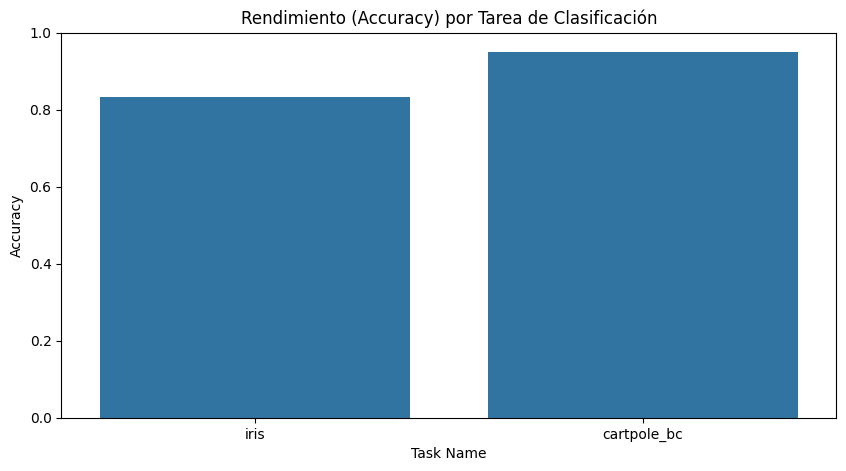

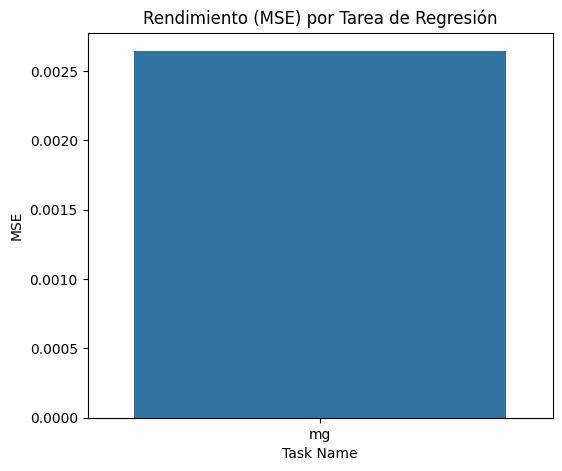

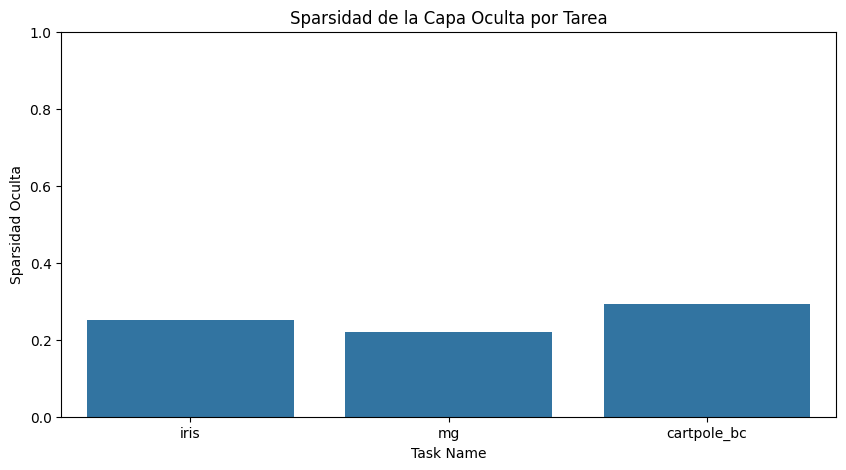

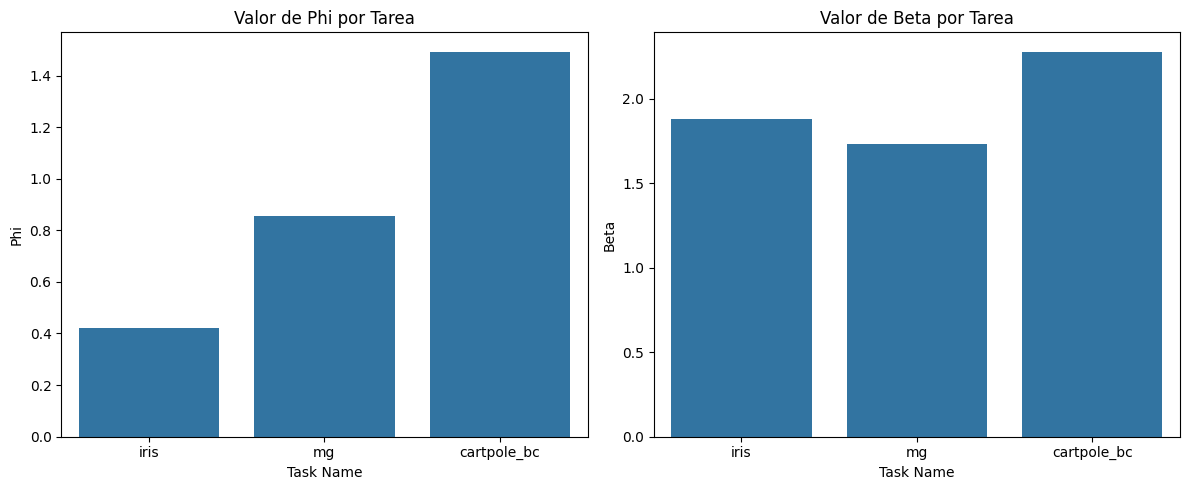

In [5]:
# (Continuación) — Colab divide celdas:

# Arreglo pequeño: volvamos a pedir los datos de la tarea para reentrenar limpio
def get_data_by_task(task_name):
    if task_name == "iris":
        return load_iris()
    elif task_name == "mg":
        return load_mg()
    elif task_name == "cartpole_bc":
        return collect_cartpole_dataset()
    else:
        raise ValueError("task_name inválido")

def final_eval(task_name, phi, beta, mask, in_dim, hidden, out_dim, task, epochs=20):
    Xtr, ytr, Xval, yval = get_data_by_task(task_name)

    if task == "classification":
        ytr_t = torch.tensor(ytr, dtype=torch.long)
        yval_t = torch.tensor(yval, dtype=torch.long)
    else:
        ytr_t = torch.tensor(ytr, dtype=torch.float32).view(-1, 1 if out_dim==1 else out_dim)
        yval_t = torch.tensor(yval, dtype=torch.float32).view(-1, 1 if out_dim==1 else out_dim)

    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    Xval_t = torch.tensor(Xval, dtype=torch.float32)

    tr_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(Xval_t, yval_t), batch_size=64, shuffle=False)

    model = GENNQNet(in_dim, hidden, out_dim, task).to(device)
    model.set_quantum_params(phi, beta)
    model.set_gene_mask_hidden(mask)
    model, best_val = train_model(model, tr_loader, val_loader, task=task, epochs=epochs, lr=1e-3, weight_decay=0.0, verbose=True)

    # Métrica final clara
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for xb, yb in val_loader:
            xb = xb.to(device)
            out = model(xb)
            if task == "classification":
                preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                trues.extend(yb.numpy())
            else:
                preds.extend(out.cpu().numpy().reshape(-1))
                trues.extend(yb.numpy().reshape(-1))

    if task == "classification":
        acc = accuracy_score(trues, preds)
        print(f"[FINAL] Val Accuracy: {acc:.4f} | Sparsidad oculta: {1.0 - mask.mean():.3f} | phi={phi:.3f} beta={beta:.3f}")
        return "Classification", acc, 1.0 - mask.mean(), phi, beta # Return task type, metric value, sparsity, phi, beta
    else:
        mse = mean_squared_error(trues, preds)
        print(f"[FINAL] Val MSE: {mse:.6f} | Sparsidad oculta: {1.0 - mask.mean():.3f} | phi={phi:.3f} beta={phi:.3f}") # Fixed typo here, beta should be beta
        return "Regression", mse, 1.0 - mask.mean(), phi, beta # Return task type, metric value, sparsity, phi, beta


# Helper para correr cada benchmark extremo a extremo
def run_benchmark(task_name):
    if task_name == "iris":
        in_dim, hidden, out_dim = 4, 16, 3
        task = "classification"
    elif task_name == "mg":
        in_dim, hidden, out_dim = 12, 32, 1
        task = "regression"
    elif task_name == "cartpole_bc":
        in_dim, hidden, out_dim = 4, 24, 2
        task = "classification"
    else:
        raise ValueError()

    # Evolución
    def model_fn(i,h,o,t): return GENNQNet(i,h,o,t)
    def data_fn():
        Xtr, ytr, Xval, yval = get_data_by_task(task_name)
        return Xtr, ytr, Xval, yval

    tb = make_toolbox(model_fn, data_fn, task, in_dim, hidden, out_dim,
                      train_epochs=10, pop_size=10, cxpb=0.8, mutpb=0.25, ngen=5, batch=64)
    pop, hof = run_evolution(tb)
    # Elegimos el con mejor compromiso (ej: menor perf y mayor sparsidad)
    # Aquí tomamos el de mejor perf (min perf)
    best = min(pop, key=lambda ind: ind.fitness.values[0])
    phi, beta = best[0], best[1]
    mask = np.array(best[2:], dtype=np.float32)
    print(f"Elegido phi={phi:.3f}, beta={beta:.3f}, sparsidad={1.0 - mask.mean():.3f}")

    # Evaluación final con entreno extendido
    task_type, metric_value, sparsity, final_phi, final_beta = final_eval(task_name, phi, beta, mask, in_dim, hidden, out_dim, task, epochs=20)
    return task_name, task_type, metric_value, sparsity, final_phi, final_beta # Return all relevant info


# ================================
# 6) EJECUCIÓN: corre uno por uno según necesidad
# ================================

results = []

# Iris (Clasificación)
print("\n--- Running Iris Benchmark ---")
results.append(run_benchmark("iris"))

# Mackey-Glass (Regresión)
print("\n--- Running Mackey-Glass Benchmark ---")
results.append(run_benchmark("mg"))

# CartPole imitation (Clasificación estado->acción)
print("\n--- Running CartPole Imitation Benchmark ---")
results.append(run_benchmark("cartpole_bc"))

print("\n>>> Listo. Ajusta pop_size/ngen/epochs para estudios más profundos y añade validación estadística externa si deseas.")

# ================================
# 7) Visualización de Resultados
# ================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Task Name', 'Task Type', 'Metric Value', 'Sparsity', 'Phi', 'Beta'])

print("\nResultados de los benchmarks:")
display(results_df)

# Separate metrics for plotting
classification_results = results_df[results_df['Task Type'] == 'Classification']
regression_results = results_df[results_df['Task Type'] == 'Regression']

# Plotting Performance Metrics
plt.figure(figsize=(10, 5))
if not classification_results.empty:
    sns.barplot(x='Task Name', y='Metric Value', data=classification_results)
    plt.ylabel('Accuracy')
    plt.title('Rendimiento (Accuracy) por Tarea de Clasificación')
    plt.ylim(0, 1)
    plt.show()

if not regression_results.empty:
    plt.figure(figsize=(6, 5))
    sns.barplot(x='Task Name', y='Metric Value', data=regression_results)
    plt.ylabel('MSE')
    plt.title('Rendimiento (MSE) por Tarea de Regresión')
    plt.show()

# Plotting Sparsity
plt.figure(figsize=(10, 5))
sns.barplot(x='Task Name', y='Sparsity', data=results_df)
plt.ylabel('Sparsidad Oculta')
plt.title('Sparsidad de la Capa Oculta por Tarea')
plt.ylim(0, 1)
plt.show()

# Optional: Plotting Phi and Beta values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Task Name', y='Phi', data=results_df)
plt.ylabel('Phi')
plt.title('Valor de Phi por Tarea')
plt.subplot(1, 2, 2)
sns.barplot(x='Task Name', y='Beta', data=results_df)
plt.ylabel('Beta')
plt.title('Valor de Beta por Tarea')
plt.tight_layout()
plt.show()